In [1]:
import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("ethancratchley/email-phishing-dataset")

print("Path to dataset files:", path)

email_df = pd.read_csv(path + "/email_phishing_data.csv")
email_df.head()



Path to dataset files: /kaggle/input/email-phishing-dataset


,num_words,num_unique_words,num_stopwords,num_links,num_unique_domains,num_email_addresses,num_spelling_errors,num_urgent_keywords,label
0,140,94,52,0,0,0,0,0,0
1,5,5,1,0,0,0,0,0,0
2,34,32,15,0,0,0,0,0,0
3,6,6,2,0,0,0,0,0,0
4,9,9,2,0,0,0,0,0,0


## Rename the labels as Spam or Not Spam

In [2]:
email_df['label'] = email_df['label'].replace({0: 'Not Spam', 1: 'Spam'})
email_df['label'].value_counts()



,count
label,
Not Spam,517897
Spam,6949


## Plots to show the Distributions

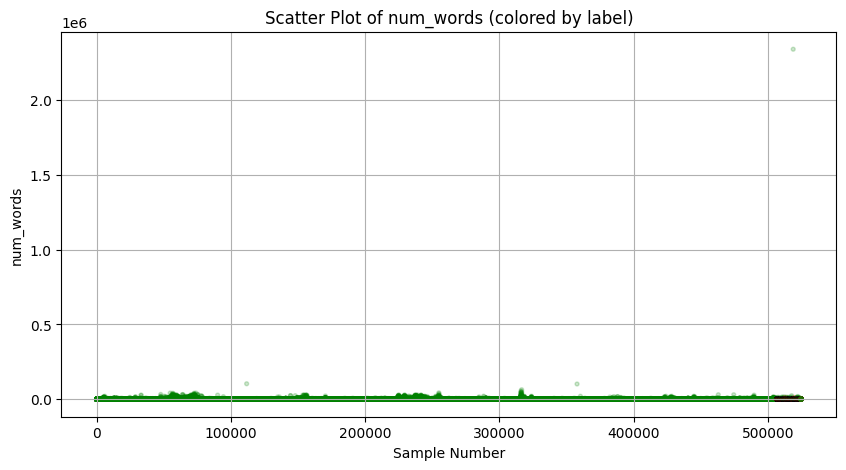

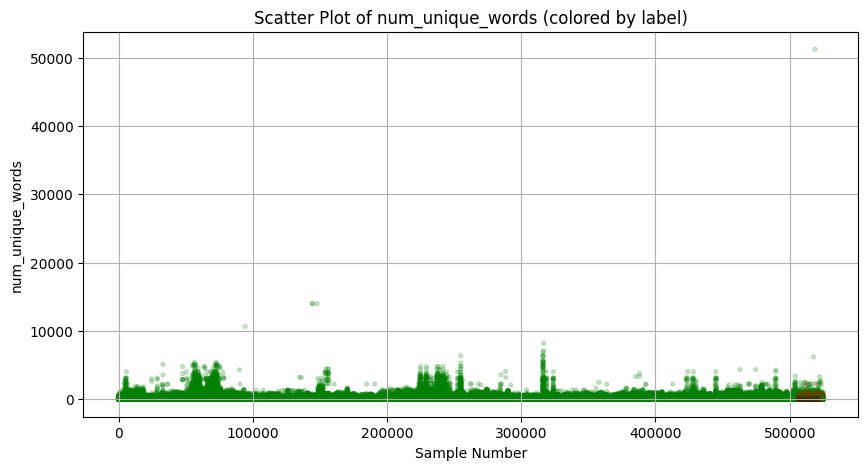

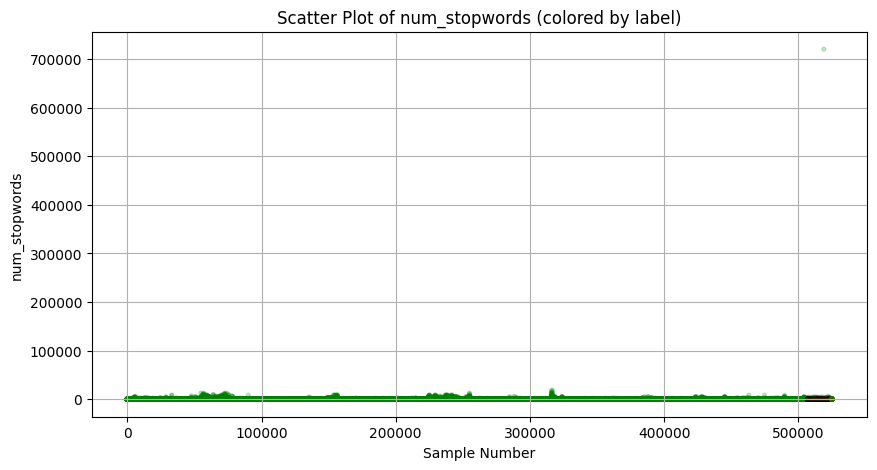

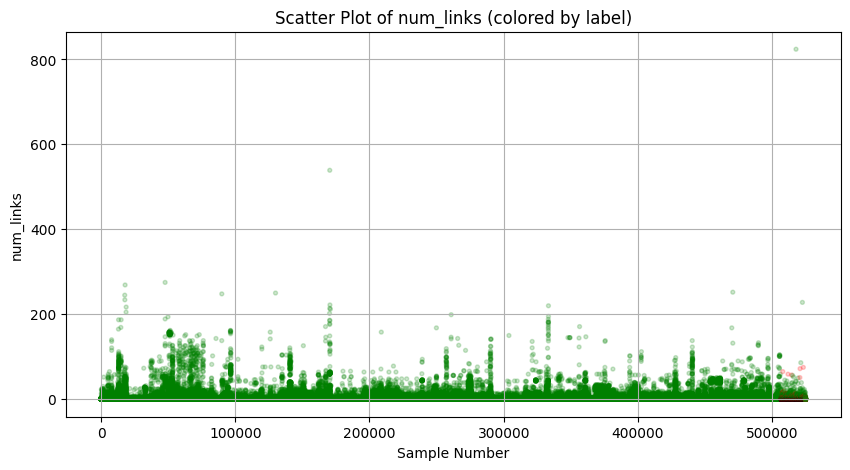

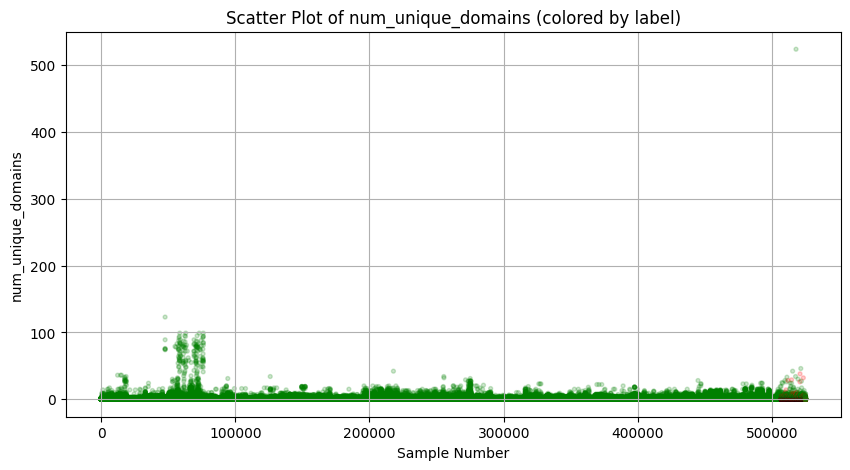

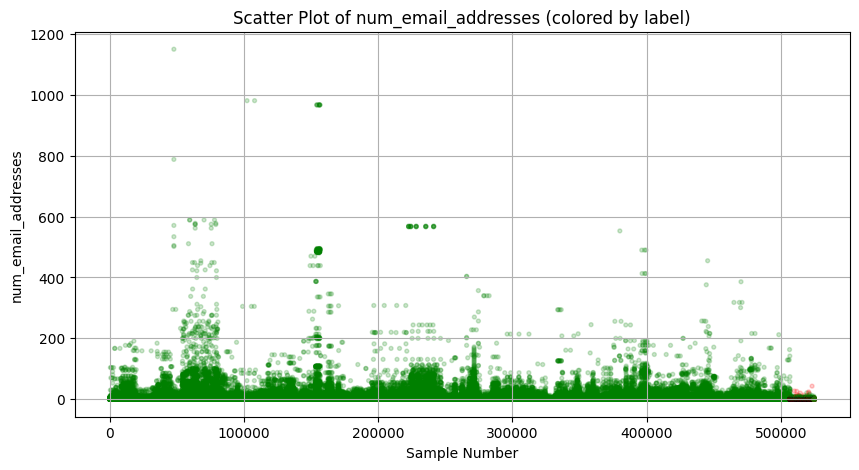

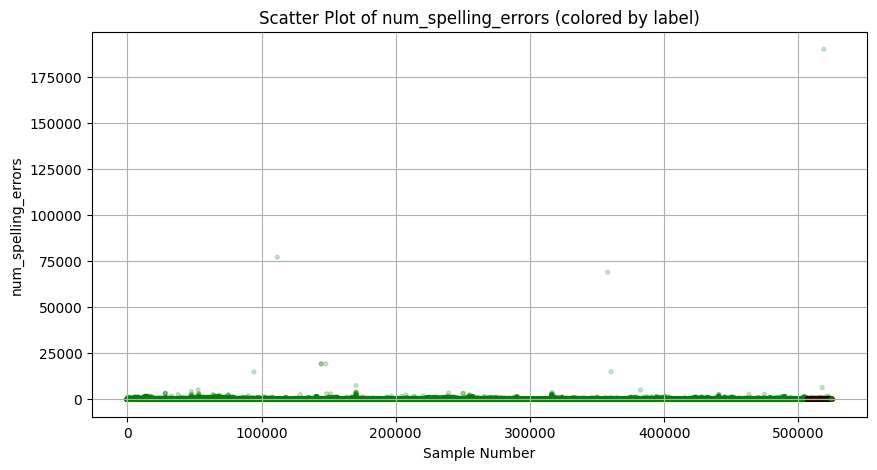

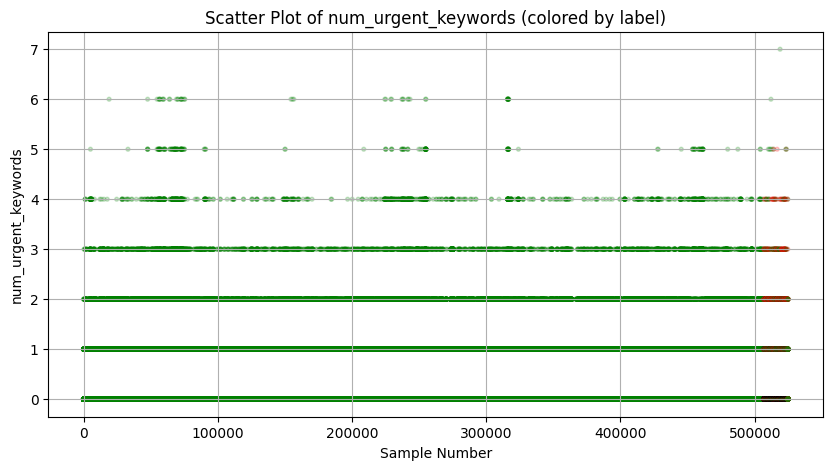

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns


#email_df = email_df[email_df['num_words'] < 100000]
#email_df = email_df[email_df['num_unique_words'] < 10000]
#email_df = email_df[email_df['num_unique_domains'] < 500]
#email_df = email_df[email_df['num_links'] < 500]

color_map = {'Spam': 'red', 'Not Spam': 'green'}
colors = email_df['label'].map(color_map)

numeric_cols = email_df.select_dtypes(include='number').columns

for col in numeric_cols:
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(email_df)), email_df[col], c=colors, alpha=0.2, s=8)  # smaller & more transparent
    plt.title(f'Scatter Plot of {col} (colored by label)')
    plt.xlabel('Sample Number')
    plt.ylabel(col)
    plt.grid(True)
    plt.show()




## Now we balance the Data sets

In [20]:
pass_to_fail_ratio = 1
not_spam_df = email_df[email_df['label'] == 'Not Spam']
spam_df = email_df[email_df['label'] == 'Spam']

not_spam_sampled = not_spam_df.sample(n=int(pass_to_fail_ratio  * len(spam_df)), random_state=33)

balanced_df = pd.concat([not_spam_sampled, spam_df], axis=0)

balanced_df = balanced_df.sample(frac=1, random_state=33).reset_index(drop=True)

balanced_df['label'].value_counts()




,count
label,
Spam,6949
Not Spam,6949


## Some more Visualizations for the Now Balanced DF

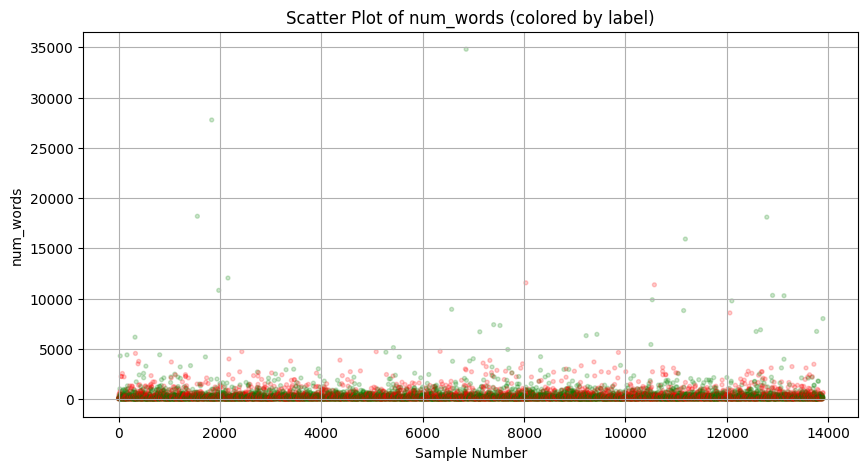

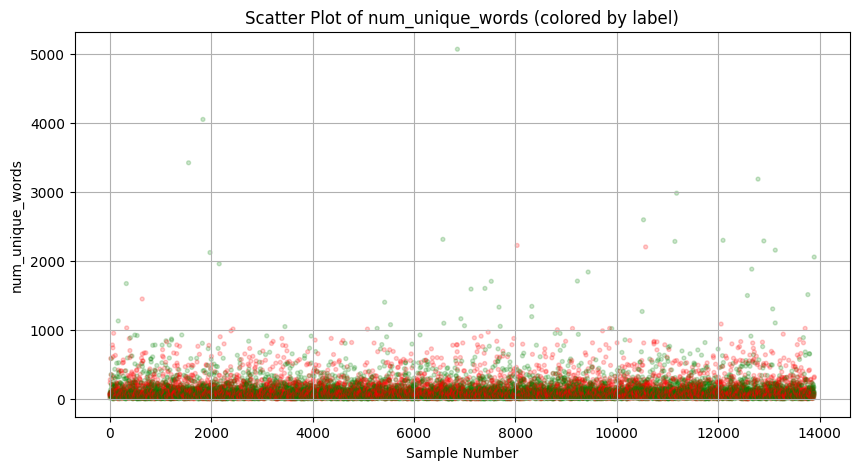

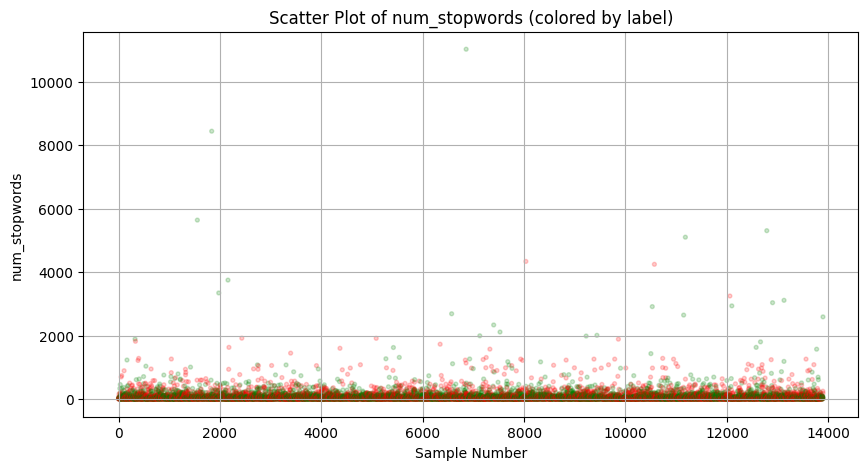

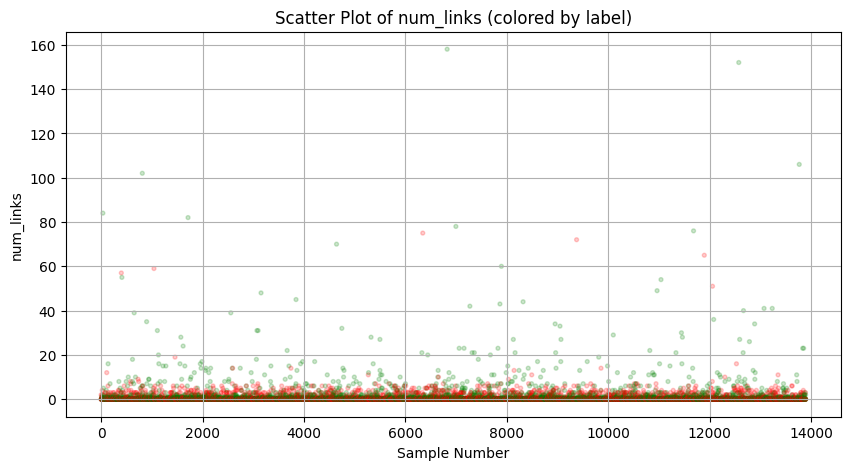

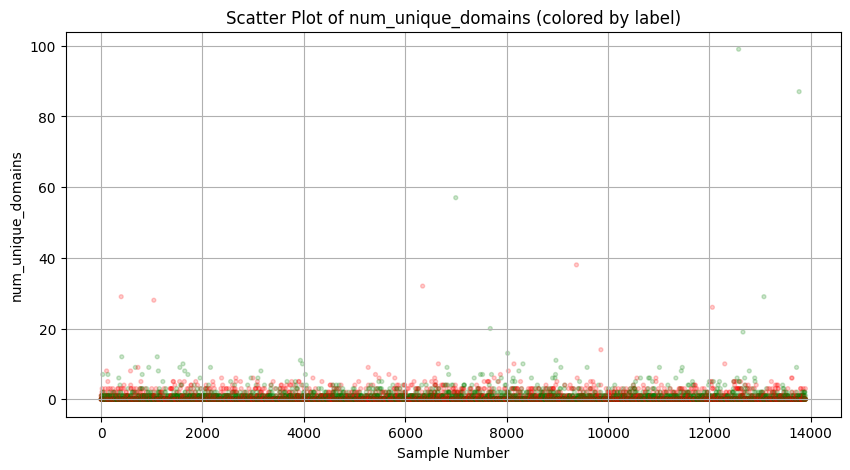

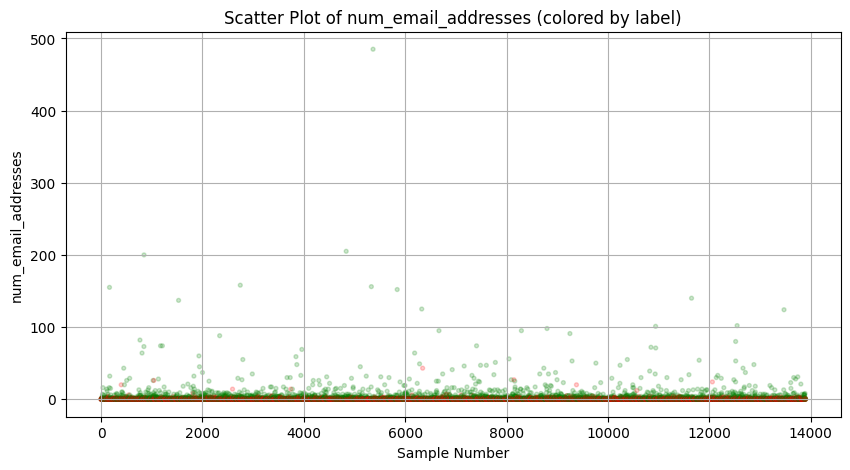

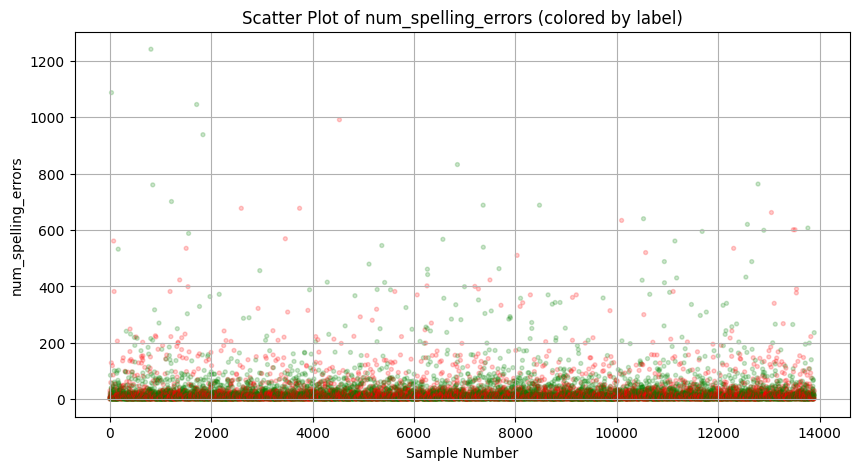

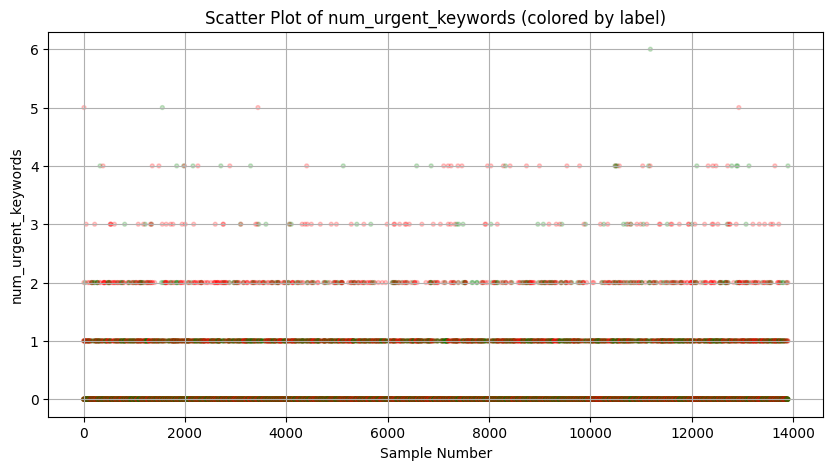

In [22]:
colors = balanced_df ['label'].map(color_map)


for col in numeric_cols:
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(balanced_df )), balanced_df [col], c=colors, alpha=0.2, s=8)  # smaller & more transparent
    plt.title(f'Scatter Plot of {col} (colored by label)')
    plt.xlabel('Sample Number')
    plt.ylabel(col)
    plt.grid(True)
    plt.show()

## Split the balanced data frame to train.

In [5]:
from sklearn.model_selection import train_test_split
email_df_train, email_df_test = train_test_split(balanced_df, test_size=0.2)
print(f"Size of email train set: {len(email_df_train)} \n email test set: {len(email_df_test)}\n")

print("Email Train:" ,email_df_train['label'].value_counts(),'\n')

print("Email Test:" ,email_df_test['label'].value_counts())


Size of email train set: 11118 
 email test set: 2780

Email Train: label
Spam        5585
Not Spam    5533
Name: count, dtype: int64 

Email Test: label
Not Spam    1416
Spam        1364
Name: count, dtype: int64


## Split the Outcome from the Train set

In [6]:
email_df_train_outcome = email_df_train['label']
email_df_train_outcome
email_df_train_no_classification = email_df_train.drop('label', axis=1)
email_df_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 11118 entries, 7066 to 10591
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   num_words            11118 non-null  int64 
 1   num_unique_words     11118 non-null  int64 
 2   num_stopwords        11118 non-null  int64 
 3   num_links            11118 non-null  int64 
 4   num_unique_domains   11118 non-null  int64 
 5   num_email_addresses  11118 non-null  int64 
 6   num_spelling_errors  11118 non-null  int64 
 7   num_urgent_keywords  11118 non-null  int64 
 8   label                11118 non-null  object
dtypes: int64(8), object(1)
memory usage: 868.6+ KB


## Split Test Set

In [7]:
email_df_test_outcome = email_df_test['label']
email_df_test_outcome
email_df_test_no_classification = email_df_test.drop('label', axis=1)
email_df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2780 entries, 3822 to 4730
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   num_words            2780 non-null   int64 
 1   num_unique_words     2780 non-null   int64 
 2   num_stopwords        2780 non-null   int64 
 3   num_links            2780 non-null   int64 
 4   num_unique_domains   2780 non-null   int64 
 5   num_email_addresses  2780 non-null   int64 
 6   num_spelling_errors  2780 non-null   int64 
 7   num_urgent_keywords  2780 non-null   int64 
 8   label                2780 non-null   object
dtypes: int64(8), object(1)
memory usage: 217.2+ KB


## Now to Train the classifier

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=33)
sgd_clf.fit(email_df_train_no_classification, email_df_train_outcome)

SGDClassifier(random_state=33)

## Scoring

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# WOW MUCH ACCURACY, that doesnt work
#cross_val_score(sgd_clf, email_df_train_no_classification, email_df_train_outcome, cv=3, scoring="accuracy")

train_pred = sgd_clf.predict(email_df_train_no_classification)
# print(y_train_pred)


from sklearn.metrics import confusion_matrix

cm = confusion_matrix(email_df_train_outcome,train_pred, )
cm

array([[5223,  310],
       [4769,  816]])

In [23]:
from sklearn.metrics import precision_score, recall_score
label_map = {'Not Spam': 0, 'Spam': 1}
y_true = email_df_train_outcome.map(label_map)
y_pred = pd.Series(train_pred).map(label_map)

print(f"Precision Score: {precision_score(y_true, y_pred)}")
print(f"Recall Score: {recall_score(y_true, y_pred)}")



train_pred_test = sgd_clf.predict( email_df_test_no_classification, )
# print(y_train_pred)

y_true = email_df_test_outcome.map(label_map)
y_pred = pd.Series(train_pred_test).map(label_map)

print(f"Precision Score: {precision_score(y_true, y_pred)}")
print(f"Recall Score: {recall_score(y_true, y_pred)}")

Precision Score: 0.7246891651865008
Recall Score: 0.14610564010743063
Precision Score: 0.72
Recall Score: 0.13196480938416422


### Conclusion
#### This is not the best Outcome.
#### Approximately 40 percent of not spam is classified to be spam in the Training set, and almost 50% of the non spam is flagged in the Test set.
#### We are Catching 75% of the spam emails from Train set, and only 63% from the Test set.

## Classification using Support Vector Machine

In [14]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Define pipeline
svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale', random_state=33))
])

# Train
svm_clf.fit(email_df_train_no_classification, email_df_train_outcome)

# Predict on train
y_pred_train = svm_clf.predict(email_df_train_no_classification)

# Predict on test
X_test = email_df_test.drop('label', axis=1)
y_test = email_df_test['label']
y_pred_test = svm_clf.predict(X_test)

# --- Evaluation on Train Set ---
print("Evaluation on TRAIN Set:")
print("Confusion Matrix:\n", confusion_matrix(email_df_train_outcome, y_pred_train))
print("Precision:", precision_score(email_df_train_outcome, y_pred_train, pos_label='Spam'))
print("Recall:", recall_score(email_df_train_outcome, y_pred_train, pos_label='Spam'))
print("F1 Score:", f1_score(email_df_train_outcome, y_pred_train, pos_label='Spam'),"\n\n")

# --- Evaluation on Test Set ---
print("\nEvaluation on TEST Set:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test, pos_label='Spam'))
print("Recall:", recall_score(y_test, y_pred_test, pos_label='Spam'))
print("F1 Score:", f1_score(y_test, y_pred_test, pos_label='Spam'),"\n\n")


Evaluation on TRAIN Set:
Confusion Matrix:
 [[3972 1561]
 [1556 4029]]
Precision: 0.7207513416815743
Recall: 0.7213965980304387
F1 Score: 0.7210738255033557 



Evaluation on TEST Set:
Confusion Matrix:
 [[1021  395]
 [ 399  965]]
Precision: 0.7095588235294118
Recall: 0.7074780058651027
F1 Score: 0.7085168869309838 




Decision Trees

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Step 1: Define the Decision Tree Classifier with depth limit to prevent overfitting
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=33)

# Step 2: Train on training data
tree_clf.fit(email_df_train_no_classification, email_df_train_outcome)

# Step 3: Predict on train
y_pred_train_tree = tree_clf.predict(email_df_train_no_classification)

# Step 4: Predict on test
X_test = email_df_test.drop('label', axis=1)
y_test = email_df_test['label']
y_pred_test_tree = tree_clf.predict(X_test)

# Step 5: Evaluation on TRAIN Set
print("Decision Tree - TRAIN Set Evaluation:")
print("Confusion Matrix:\n", confusion_matrix(email_df_train_outcome, y_pred_train_tree))
print("Precision:", precision_score(email_df_train_outcome, y_pred_train_tree, pos_label='Spam'))
print("Recall:", recall_score(email_df_train_outcome, y_pred_train_tree, pos_label='Spam'))
print("F1 Score:", f1_score(email_df_train_outcome, y_pred_train_tree, pos_label='Spam'),"\n\n")

# Step 6: Evaluation on TEST Set
print("Decision Tree - TEST Set Evaluation:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_tree))
print("Precision:", precision_score(y_test, y_pred_test_tree, pos_label='Spam'))
print("Recall:", recall_score(y_test, y_pred_test_tree, pos_label='Spam'))
print("F1 Score:", f1_score(y_test, y_pred_test_tree, pos_label='Spam'),"\n\n")


Decision Tree - TRAIN Set Evaluation:
Confusion Matrix:
 [[3055 2478]
 [ 974 4611]]
Precision: 0.6504443504020313
Recall: 0.8256042972247091
F1 Score: 0.727631371311346
Decision Tree - TEST Set Evaluation:
Confusion Matrix:
 [[ 748  668]
 [ 243 1121]]
Precision: 0.626607043040805
Recall: 0.8218475073313783
F1 Score: 0.711068823342848


In [16]:
tree_clf

DecisionTreeClassifier(max_depth=5, random_state=33)